In [23]:
import os
import re
import h5py
import keras
import urllib
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras import metrics
from keras import backend as K
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16
from collections import OrderedDict, Counter
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.applications.xception import Xception
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

%matplotlib inline
sns.set_style('white')
plt.style.use('bmh')

## Downloading images, converting them to numpy arrays

In [2]:
df = pd.read_json('data/themoviedb-sample-4-17-2017.json')
df = df[df['poster_path'].isnull() == False]
df['poster_url'] = df['poster_path'].apply(lambda x: 'http://image.tmdb.org/t/p/w92{}'.format(x))
df = df[['title', 'genre', 'poster_url']]
print(df.shape)
df.head()

(9175, 3)


,title,genre,poster_url
0,Bought,Documentary,http://image.tmdb.org/t/p/w92/5q3CQLHMbvsjxK4V...
1,Egypt Underworld,Documentary,http://image.tmdb.org/t/p/w92/vHZf7KA7RGMxWl2r...
2,Chinese Heroes,Action,http://image.tmdb.org/t/p/w92/74F1NxjpQFoXoJzG...
3,Shakedown,Action,http://image.tmdb.org/t/p/w92/eILw7xfKn99cPU6n...
4,Shakedown,Drama,http://image.tmdb.org/t/p/w92/eILw7xfKn99cPU6n...


#### Downloading all the posters
Here, we download them at the smallest size (width = 92 pixels). 

In [24]:
# for url in df['poster_url'].unique():
#     file_name = re.findall(r'(?<=w92\/)(.*)', url)[0]
#     if file_name not in os.listdir('data/img'):
#         urllib.urlretrieve(url, 'data/img/{}'.format(file_name))

#### Flattening into numpy arrays
Resizing images to `(138, 92, 3)`. I expect this will lose us some precision later.

In [3]:
images = []
y = []

for image_file in os.listdir('data/img'):
    img = load_img('data/img/{}'.format(image_file))
    images.append(np.resize(img_to_array(img),(138,92,3)))
    y.append(np.array([x for x in df[df['poster_url'] == 'http://image.tmdb.org/t/p/w92/{}'.format(image_file)]['genre'].values]))


## $y$: Multi-label

In [4]:
y[0:5]

[array([u'Drama', u'Horror'], 
       dtype='<U6'), array([u'Documentary'], 
       dtype='<U11'), array([u'Drama', u'Romance'], 
       dtype='<U7'), array([u'Adventure', u'Comedy'], 
       dtype='<U9'), array([u'Comedy', u'Family', u'Fantasy', u'Science Fiction'], 
       dtype='<U15')]

In [5]:
X = np.array(images)

# Normalizing away from 255
X = X / 255.

# Saving it for later
np.save('data/X_array.npy', X)

input_shape = X.shape
print(input_shape)

(4722, 138, 92, 3)


In [6]:
all_genres = pd.DataFrame(index = range(0,4722))

for row in y:
    for genre in row:
        if genre in all_genres:
            pass
        else:
            all_genres[genre] = 0

for index, row in enumerate(y):
    for genre in row:
        all_genres[genre].loc[index] = 1
        
print(all_genres.shape)
all_genres.head()

(4722, 20)


,Drama,Horror,Documentary,Romance,Adventure,Comedy,Family,Fantasy,Science Fiction,Foreign,Action,Crime,Music,Thriller,TV Movie,History,Mystery,Animation,War,Western
0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0


In [7]:
Y = np.array(all_genres)
print(Y.shape)

(4722, 20)


In [8]:
print("Most movies have {:.3f} genres.".format(all_genres.sum(axis = 1).mean()))

Most movies have 1.935 genres.


#### Fitting a simple CNN model

In [9]:
# Super simple CNN
model = Sequential()

# Input layer
model.add(Conv2D(50, activation='relu', 
                 kernel_size=(2, 2),
                 data_format = 'channels_last',
                 input_shape=(138,92,3)))

# --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))

# --- next layer ---
# we could double the number of filters as max pool made the 
# feature maps much smaller 
# just not doing this to improve runtime
model.add(Conv2D(100, kernel_size=(3, 3), activation='relu'))
# --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))

# --- next layer ---
model.add(Conv2D(50, kernel_size=(3, 3), activation='relu'))
# --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))

# # --- next layer ---
model.add(Conv2D(100, kernel_size=(3, 3), activation='relu'))
# # --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten for fully connected classification layer
model.add(Flatten())
# --- fully connected layer ---
model.add(Dense(50, activation='relu'))
# --- classification ---
model.add(Dense(20, activation='sigmoid'))

# prints out a summary of the model architecture
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 137, 91, 50)       650       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 68, 45, 50)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 66, 43, 100)       45100     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 33, 21, 100)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 19, 50)        45050     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 9, 50)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 7, 100)        45100     
__________

In [10]:
sgd = SGD(lr=0.001, momentum=0.9)
model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['mae', metrics.categorical_accuracy])

In [11]:
batch_size = 12
early_stopping_monitor = EarlyStopping(patience = 3)

history = model.fit(X, Y,
                    validation_split = 0.2,
                    batch_size=batch_size,
                    epochs = 10,
                    callbacks = [early_stopping_monitor],
                    verbose=1)


Train on 3777 samples, validate on 945 samples
Epoch 1/10
3777/3777 [==============================] - 13s - loss: 0.4769 - mean_absolute_error: 0.3296 - categorical_accuracy: 0.1700 - val_loss: 0.2942 - val_mean_absolute_error: 0.1687 - val_categorical_accuracy: 0.3280

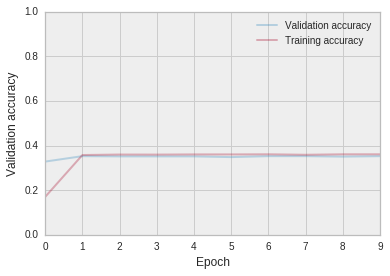

In [12]:
plt.plot(history.history['val_categorical_accuracy'], alpha = 0.3, label = 'Validation accuracy')
plt.plot(history.history['categorical_accuracy'], alpha =  0.3, label = 'Training accuracy')
plt.xlabel("Epoch")
plt.ylabel("Validation accuracy")
plt.ylim([0,1])
plt.legend(loc = 'best')
plt.show()

In [13]:
preds = model.predict(X[0:4])
Y[0], preds[0]

(array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([ 0.37998262,  0.11928431,  0.23291183,  0.10892615,  0.06973641,
         0.22744909,  0.07230696,  0.05633553,  0.05809229,  0.01910016,
         0.14558198,  0.07097724,  0.09173265,  0.18359524,  0.03941693,
         0.02527272,  0.04389515,  0.06047521,  0.01719251,  0.01140031], dtype=float32))

<hr>

## Pretrained model: ResNet50

In [30]:
new_model = Xception(weights='imagenet', include_top = False, input_shape=(138,92,3))
new_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_6 (InputLayer)             (None, 138, 92, 3)    0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 68, 45, 32)    864                                          
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 68, 45, 32)    128                                          
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 68, 45, 32)    0                                            
___________________________________________________________________________________________

In [34]:
sgd = SGD(lr=0.1, momentum=0.9)
new_model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['mae', metrics.categorical_accuracy])

In [35]:
batch_size = 12
early_stopping_monitor = EarlyStopping(patience = 3)

history = new_model.fit(X, Y,
                    validation_split = 0.2,
                    batch_size=batch_size,
                    epochs = 10,
                    callbacks = [early_stopping_monitor],
                    verbose=1)

ValueError: Error when checking model target: expected block14_sepconv2_act to have 4 dimensions, but got array with shape (4722, 20)


<hr>

## $y$: Most popular single genre

In [29]:
all_genres = [list(x) for x in y]
all_genres_list = [item for sublist in all_genres for item in sublist]
print(len(all_genres_list))
all_genres[0:5]

9175


[[u'Drama', u'Horror'],
 [u'Documentary'],
 [u'Drama', u'Romance'],
 [u'Adventure', u'Comedy'],
 [u'Comedy', u'Family', u'Fantasy', u'Science Fiction']]

In [41]:
top_genres = Counter(all_genres_list).most_common(20)
new_y = []

for row in y:
    new_row_genre = 'other'
    for genre in row:
        if new_row_genre == 'other' and genre in OrderedDict(top_genres):
            new_row_genre = genre
        else:
            pass
    new_y.append(new_row_genre)


y[0], new_y[0]

(array([u'Drama', u'Horror'], 
       dtype='<U6'), u'Drama')

In [49]:
all_single_genres = pd.DataFrame(index = range(0,4722))

for genre in new_y:
    if genre in all_single_genres:
        pass
    else:
        all_single_genres[genre] = 0

for index, row in enumerate(new_y):
    all_single_genres[genre].loc[index] = 1
        
print(all_single_genres.shape)
all_single_genres.head()

(4722, 20)


,Drama,Documentary,Adventure,Comedy,Action,Music,Horror,TV Movie,Thriller,Family,Animation,Romance,Crime,Mystery,War,Science Fiction,Western,Fantasy,History,Foreign
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [50]:
print("Most movies have {:.3f} genres.".format(all_single_genres.sum(axis = 1).mean()))

Most movies have 1.000 genres.


In [51]:
Y_new = np.array(all_single_genres)
print(Y_new.shape)

(4722, 20)


#### CNN, again!

In [58]:
# Super simple CNN
model = Sequential()

# Input layer
model.add(Conv2D(80, activation='relu', 
                 kernel_size=(2, 2),
                 data_format = 'channels_last',
                 input_shape=(138,92,3)))

# --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))

# --- next layer ---
# we could double the number of filters as max pool made the 
# feature maps much smaller 
# just not doing this to improve runtime
model.add(Conv2D(100, kernel_size=(3, 3), activation='relu'))
# --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))

# --- next layer ---
model.add(Conv2D(100, kernel_size=(3, 3), activation='relu'))
# --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))

# # --- next layer ---
model.add(Conv2D(100, kernel_size=(3, 3), activation='relu'))
# # --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten for fully connected classification layer
model.add(Flatten())
# --- fully connected layer ---
model.add(Dense(64, activation='relu'))
# --- classification ---
model.add(Dense(20, activation='softmax'))

# prints out a summary of the model architecture
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 137, 91, 80)       1040      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 68, 45, 80)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 66, 43, 100)       72100     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 33, 21, 100)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 31, 19, 100)       90100     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 15, 9, 100)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 13, 7, 100)        90100     
__________

In [59]:
sgd = SGD(lr=0.1, momentum=0.9)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['acc', 'mae', metrics.categorical_accuracy])

batch_size = 12
early_stopping_monitor = EarlyStopping(patience = 3)

# Multi-class prediction: single genre!
new_history = model.fit(X, Y_new,
                    validation_split = 0.2,
                    batch_size=batch_size,
                    epochs = 5,
                    callbacks = [early_stopping_monitor],
                    verbose=1)

Train on 3777 samples, validate on 945 samples
Epoch 1/5
3777/3777 [==============================] - 13s - loss: 0.0174 - acc: 0.9968 - mean_absolute_error: 5.9634e-04 - categorical_accuracy: 0.9968 - val_loss: 1.1921e-07 - val_acc: 1.0000 - val_mean_absolute_error: 0.0000e+00 - val_categorical_accuracy: 1.0000

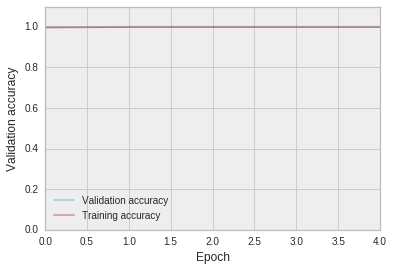

In [64]:
plt.plot(new_history.history['val_acc'], alpha = 0.3, label = 'Validation accuracy')
plt.plot(new_history.history['acc'], alpha =  0.3, label = 'Training accuracy')
plt.xlabel("Epoch")
plt.ylabel("Validation accuracy")
plt.ylim([0,1.1])
plt.legend(loc = 'best')
plt.show()

In [65]:
preds = model.predict(X[0:4])
Y_new[0], preds[0]

(array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32))